In [2]:
rm(list=ls())
libraries = c("dplyr","magrittr","tidyr","reshape2","ggplot2","ggpubr","hrbrthemes","extrafont","openxlsx","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","readr","stats","boot","pracma","stringr","mixdist","corpcor","rstan","bayesplot")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

theme_set(theme_bw())
setwd("C:/Users/USER/Documents/GitHub/2019-nCoV_ve_waning")

In [3]:
voc <- read_csv("data/VOC_simulation.csv") 
voc$week <- as.Date(voc$week)
voc %<>% mutate(Variant_type = recode(Variant, Others = "Variant A", Alpha = "Variant B", Delta = "Variant C", Omicron = "Variant D"))
voc %>% head(5);voc %>% tail(5)
A <- voc %>% filter(Variant_type == "Variant A")
B <- voc %>% filter(Variant_type == "Variant B")
C <- voc %>% filter(Variant_type == "Variant C")
D <- voc %>% filter(Variant_type == "Variant D")

Parsed with column specification:
cols(
  week = col_character(),
  Proportion = col_double(),
  Variant = col_character()
)



week,Proportion,Variant,Variant_type
<date>,<dbl>,<chr>,<chr>
2020-12-30,0,Alpha,Variant B
2021-01-03,0,Alpha,Variant B
2021-01-10,0,Alpha,Variant B
2021-01-17,0,Alpha,Variant B
2021-01-24,0,Alpha,Variant B


week,Proportion,Variant,Variant_type
<date>,<dbl>,<chr>,<chr>
2022-04-17,0.000,Others,Variant A
2022-04-24,0.008,Others,Variant A
2022-05-01,0.000,Others,Variant A
2022-05-08,0.000,Others,Variant A
2022-05-15,0.000,Others,Variant A


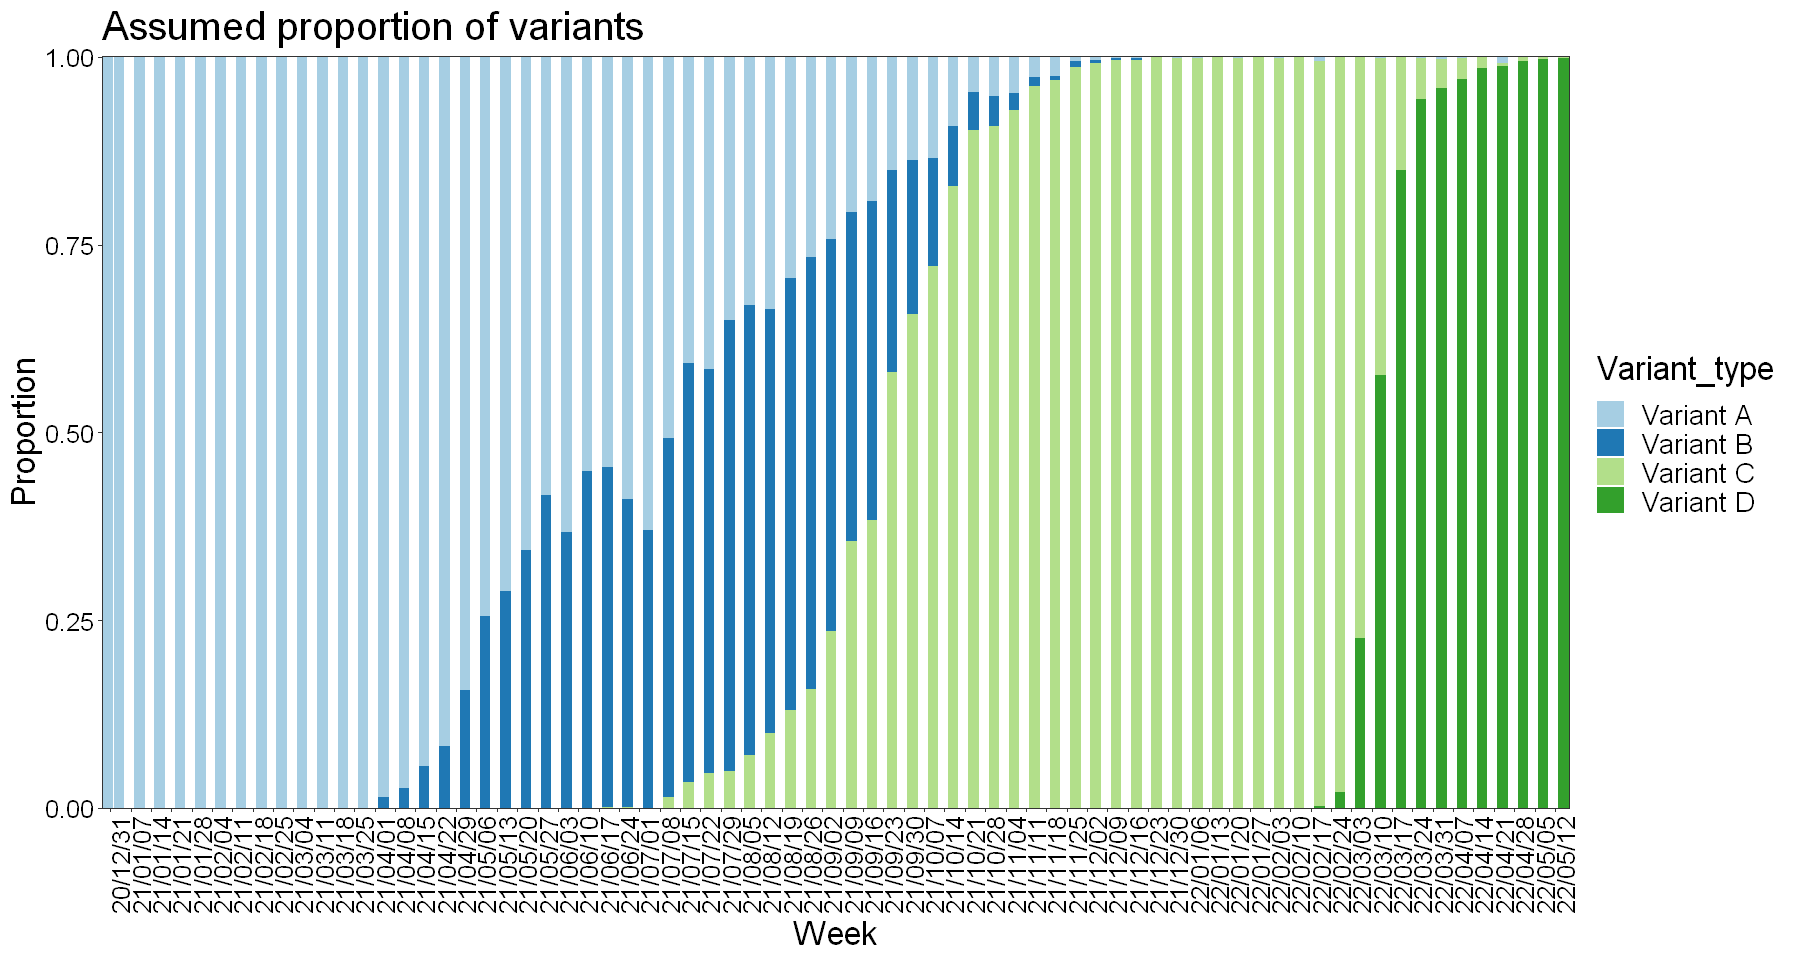

In [4]:
options(repr.plot.width=15,repr.plot.height=8)
voc %>% ggplot() +
  geom_bar(aes(x=week,y=Proportion, fill=Variant_type), stat = "identity") +
  scale_x_date(date_labels = "%y/%m/%d", date_breaks = "7 day", expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Proportion") +
  ggtitle("Assumed proportion of variants") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 90, hjust = 1),axis.text.y = element_text(size=15)) + scale_fill_brewer(palette = "Paired") + 
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) 

In [4]:
ncov_vax <- read_csv("data/vax_rollout_simulation.csv") 
ncov_vax$week <- as.Date(ncov_vax$week)
ncov_vax%>%head(5);ncov_vax%>%tail(5)

Parsed with column specification:
cols(
  week = col_character(),
  vaccine = col_double(),
  cumulative = col_double()
)



week,vaccine,cumulative
<date>,<dbl>,<dbl>
2020-12-30,14532,358776
2021-01-03,14783,373559
2021-01-10,17431,390990
2021-01-17,31970,422960
2021-01-24,97021,519981


week,vaccine,cumulative
<date>,<dbl>,<dbl>
2022-04-17,12448,12586925
2022-04-24,11167,12598092
2022-05-01,13168,12611260
2022-05-08,9513,12620773
2022-05-15,13262,12634035


### Scenario 1

In [85]:
### ve basic function
basicfn <- function(p,k,t){
    fn <- p*(1/(exp(k*(t-1)) + 1))
    return(fn)
}

ve_others <- function(t){
    fn <- basicfn(p=0.95*2,k=0.002,t)
    return(fn)
}
ve_alpha <- function(t){
    fn <- basicfn(p=0.92*2,k=0.005,t) #0.92
    return(fn)
}
ve_delta <- function(t){
    fn <- basicfn(p=0.85*2,k=0.012,t)
    return(fn)
}
ve_omicron <- function(t){
    fn <- basicfn(p=0.95*2,k=0.007,t)
    return(fn)
}


### (Scenario 2)

In [66]:
### ve basic function
basicfn <- function(p,k,t){
    fn <- p*(1/(exp(k*(t-1)) + 1))
    return(fn)
}

ve_others <- function(t){
    fn <- basicfn(p=0.98*2,k=0.002,t)
    return(fn)
}
ve_alpha <- function(t){
    fn <- basicfn(p=0.95*2,k=0.003,t)
    return(fn)
}
ve_delta <- function(t){
    fn <- basicfn(p=0.95*2,k=0.01,t)#basicfn(p=0.85*2,k=0.01,t)
    return(fn)
}
ve_omicron <- function(t){
    fn <- basicfn(p=0.85*2,k=0.02,t)#0.005
    return(fn)
}


[1] 0.85000000 0.82875443 0.80753538 0.78636926 0.76528220 0.74429995
 [7] 0.72344772 0.70275012 0.68223098 0.66191330 0.64181914 0.62196950
[13] 0.60238428 0.58308221 0.56408079 0.54539621 0.52704338 0.50903586
[19] 0.49138585 0.47410420 0.45720042 0.44068267 0.42455782 0.40883144
[25] 0.39350787 0.37859024 0.36408053 0.34997963 0.33628739 0.32300266
[31] 0.31012339 0.29764666 0.28556875 0.27388521 0.26259095 0.25168024
[37] 0.24114681 0.23098392 0.22118441 0.21174071 0.20264497 0.19388905
[43] 0.18546460 0.17736308 0.16957583 0.16209409 0.15490903 0.14801181
[49] 0.14139358 0.13504553 0.12895891 0.12312503 0.11753531 0.11218132
[55] 0.10705471 0.10214731 0.09745110 0.09295824 0.08866106 0.08455207

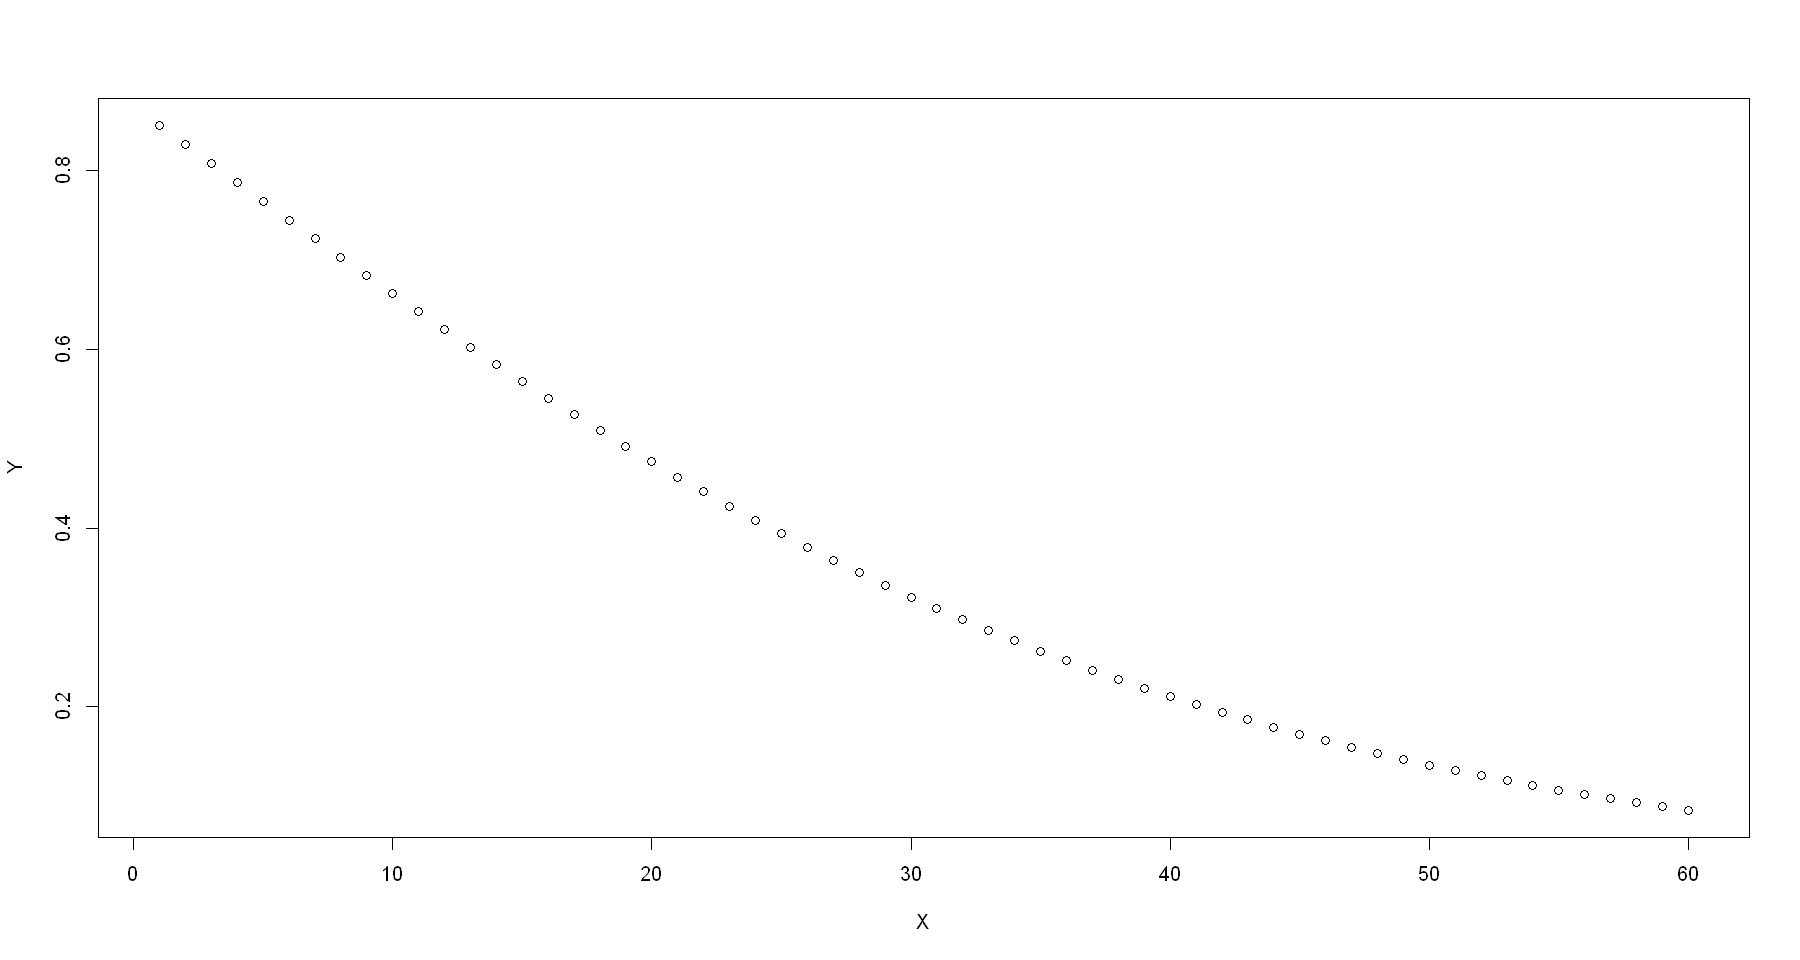

In [43]:
### check ve function
options(repr.plot.width=15,repr.plot.height=8)
X <- seq(1,60,1)
Y <- rep(0,60)
for(i in 1:60){Y[i] <- ve_delta(i)}
Y
plot(X,Y)

### simulation code

In [86]:
set.seed(12345)
T=nrow(A);
l = 3; 
N = 14826276;
Ri = rep(0,T-l); Rj = rep(0,T-l); 
i0 <- c(3300,3200,3000); j0 <- c(0,3,2); 
eta <- 100
Ci <- rep(0,T-l)
Cj <- rep(0,T-l)
zeta <- rep(0,T-l)
eps <- rep(0,T-l)
rollout <- ncov_vax$vaccine/N
se <- 0.1
GT <- function(t){plnorm(t*7, log(4.699), log(2.936))-plnorm(t*7-7, log(4.699), log(2.936))}   
it <- rep(0, T); jt <- rep(0, T);
iit <- c(i0,rep(0, T-l)); jjt <- c(j0,rep(0, T-l));

for(t in (1+l):T){
    fn_overall <- rep(0,t)
    for(tt in 1:t){
        fn_overall[tt] <- (A$Proportion[t] * ve_others(t-tt+1) +B$Proportion[t] * ve_alpha(t-tt+1) + C$Proportion[t] * ve_delta(t-tt+1) + D$Proportion[t] * ve_omicron(t-tt+1)) * rollout[tt] 
    }   
    zeta[t-l] <- sum(fn_overall[1:t])
    eps[t-l] <- rbeta(1, shape1 = zeta[t-l] * eta/sqrt(jt[t-1]+1e-4), shape2 = eta/sqrt(jt[t-1]+1e-4) - zeta[t-l] * eta/sqrt(jt[t-1]+1e-4))
    
    
    Ri[t-l] <- exp(rnorm(1,log(0.5*A$Proportion[t] + 0.5*1.5*B$Proportion[t] + 0.3*0.5*1.5*1.5*C$Proportion[t] + 0.3*0.5*1.5*1.5*1.2*D$Proportion[t]),se))#exp(rnorm(1,log(0.5),se))
    Rj[t-l] <- (1-eps[t-l]) * (sum(rollout[1:t])/(1-sum(rollout[1:t]))) * Ri[t-l] 
    
    for (tau in 2:t){it[tau-1] = Ri[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)}
    for (tau in 2:t){jt[tau-1] = Rj[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)} 
    
    iit[t] = rpois(1,sum(it[1:(t-1)])) 
    jjt[t] = rpois(1,sum(jt[1:(t-1)]))
}
llk <- rep(0,T-l)
for(t in (l+1):(T)){
    for (tau in 2:t){it[tau-1] = Ri[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)}
    for (tau in 2:t){jt[tau-1] = Rj[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)} 
    llk[t-l] = dpois(iit[t],sum(it[(1):(t-1)]),log=TRUE) + dpois(jjt[t],sum(jt[(1):(t-1)]),log=TRUE) #+ dbeta(eps[t-l],shape1 = zeta[t-l] * eta/sqrt(jt[t]+1e-4), shape2 = eta/sqrt(jt[t]+1e-4) - zeta[t-l] * eta/sqrt(jt[t]+1e-4),log=TRUE)
}
llk
sum(llk)

weeks <- as.data.frame(c(ncov_vax$week,ncov_vax$week))
case <- as.data.frame(c(iit,jjt))
Type <- as.data.frame(c(rep("Unvaccinated",T),rep("Vaccinated",T)))
df <- cbind(weeks,Type,case)
df <- as.data.frame(df)
colnames(df) <- c("Week","Type","Case")
df$Week <- as.Date(df$Week)

[1]  -6.555743  -6.608722  -6.571747  -9.772276  -7.723750  -7.317915
 [7]  -8.963150  -6.796962  -7.857370  -6.715234  -6.443359  -6.994394
[13]  -6.517483  -7.365753  -7.463057  -6.236912  -5.953855  -6.817808
[19]  -8.360191  -6.868762  -8.145247  -6.989909  -7.087838  -7.244815
[25]  -7.742347  -7.080112  -8.189549  -8.567434  -8.441279  -8.561677
[31]  -8.206684  -7.965891  -8.769214  -8.196853  -8.497278  -8.317547
[37]  -8.222882  -8.868466  -8.649078  -8.673486  -8.577440  -8.409621
[43]  -8.980578  -9.050349  -9.374086  -9.615487  -9.043159 -10.991361
[49] -12.375914  -9.066858  -8.273986  -8.338951  -8.002646  -8.354251
[55]  -8.837555  -8.405187  -8.495337  -8.308951  -8.729716  -8.581818
[61]  -8.533395  -9.942271  -8.708364  -8.724428 -10.875734 -11.755403
[67]  -9.319015 -10.613988  -9.135937 -11.737297

[1] -585.4811

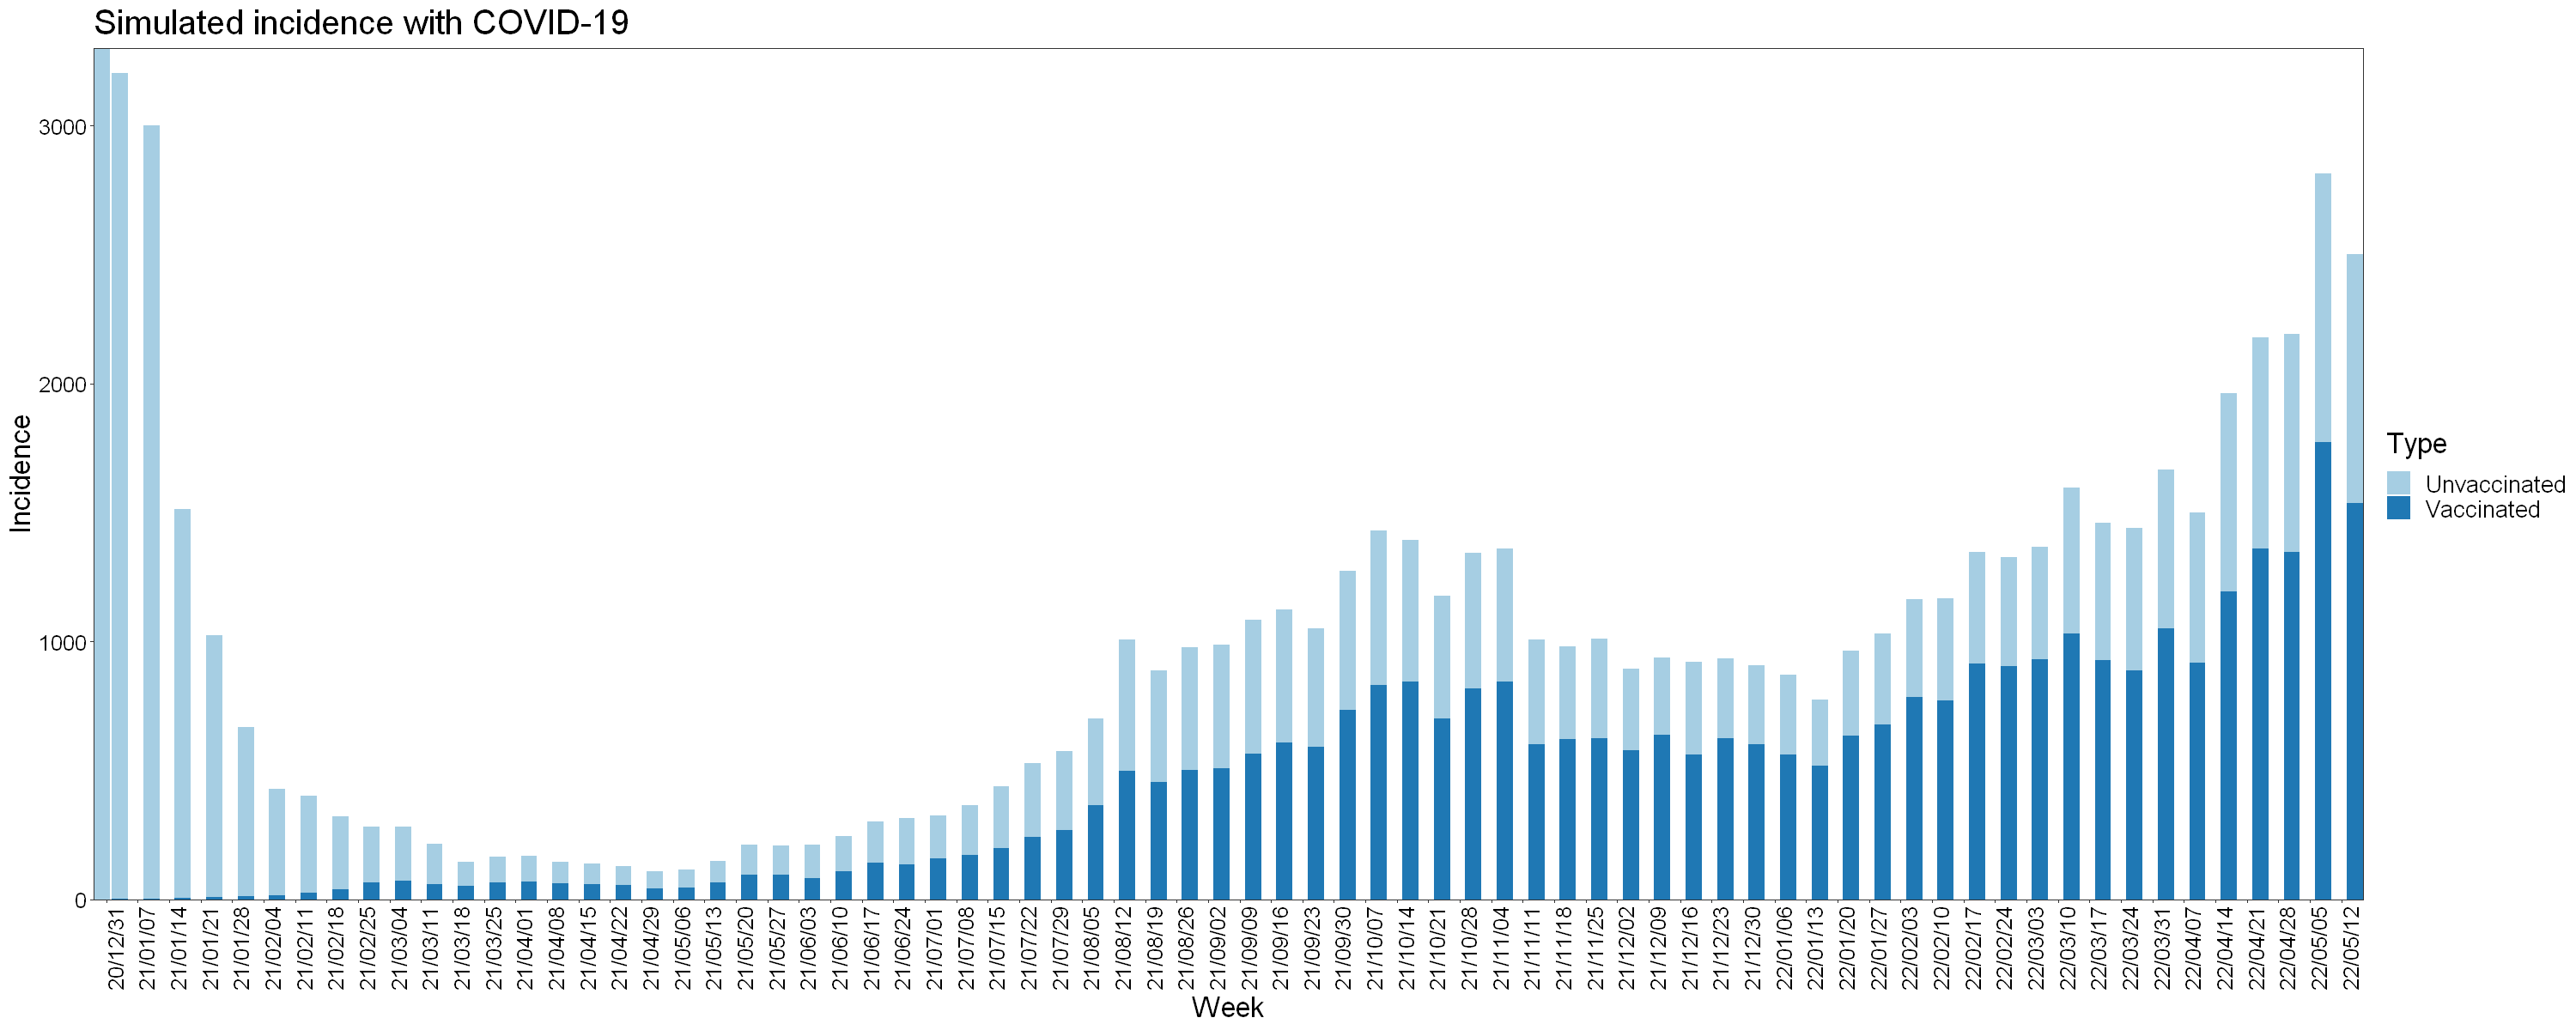

In [87]:
options(repr.plot.width=25,repr.plot.height=10)
df %>% ggplot() +
  geom_bar(aes(x=Week,y=Case, fill=Type), stat = "identity") +
  scale_x_date(date_labels = "%y/%m/%d", date_breaks = "7 day", expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Incidence") +
  ggtitle("Simulated incidence with COVID-19") + scale_fill_brewer(palette = "Paired") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 90, hjust = 1),axis.text.y = element_text(size=15)) +
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank())


In [8]:
iit;jjt

[1] 3300 3200 3000 1507 1014  658  412  374  283  215  208  156   93  101  100
[16]   82   78   73   67   68   82  115  116  130  138  164  185  172  201  251
[31]  301  325  363  553  477  526  534  583  589  531  633  717  672  591  666
[46]  668  534  489  537  459  451  539  480  486  499  430  556  602  673  714
[61]  817  812  868 1137 1096 1081 1175 1065 1353 1399 1357 1619 1411

[1]    0    3    2    8   11   12   18   27   38   66   74   60   53   65   70
[16]   63   61   56   43   47   66   99   97   85  114  150  144  167  185  215
[31]  264  296  404  559  513  571  588  667  725  719  904 1045 1083  930 1102
[46] 1158  856  904  939  890 1003  920 1013 1024  974  918 1135 1275 1454 1533
[61] 1837 1848 1930 2079 1754 1600 1814 1534 1920 2069 1960 2446 2019

In [25]:
#odds;
b <- rep(0,73)
for(t in 1:73){b[t] <-sum(rollout[1:t])/(1-sum(rollout[1:t]))}

### stan code

In [99]:
#source("src/stan/Model_Simulation_param.stan") # load functions
source("src/stan/Model_Simulation_spline.stan")
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [96]:
It <- df %>% filter(Type=="Unvaccinated") 
Jt <- df %>% filter(Type=="Vaccinated") 

In [90]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 14826276
num_data = T+l+delay
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","k","p","ii","jj")
# eps: overall effect over time, ve: direct effect over time


nuts_fit1 = stan(model_code=Model,data=data,pars=parameters,iter=5000,thin=10,warmup=1000,chain=2)


SAMPLING FOR MODEL '339f9ccdf2e3a87e8f0ae63edb73e8b6' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.021 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 210 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 5000 [ 20%]  (Sampling)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Sampling)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Sampling)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 267.722 seconds (Warm-up)
Chain 1:                637.583 seconds (Sampling)

In [100]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 14826276
num_data = T+l+delay
X = seq(1, num_data, by=1)
xknots = c(1, 40,num_data)
nknots = length(xknots)
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = b#ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data, X=X, xknots=xknots,nknots=nknots)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","log_lik","ii","jj")
# eps: overall effect over time, ve: direct effect over time
#init = list(c("eta[1]"=100,"yknots_o[1]"=logit(ve_others(1)),"yknots_a[1]"=logit(ve_alpha(1)),"yknots_d[1]"=logit(ve_delta(1)),"yknots_om[1]"=logit(ve_omicron(1)),"yknots_o[2]"=logit(ve_others(40)),"yknots_a[2]"=logit(ve_alpha(40)),"yknots_d[2]"=logit(ve_delta(40)),"yknots_om[2]"=logit(ve_omicron(40)),"yknots_o[3]"=logit(ve_others(num_data)),"yknots_a[3]"=logit(ve_alpha(num_data)),"yknots_d[3]"=logit(ve_delta(num_data)),"yknots_om[3]"=logit(ve_omicron(num_data))))
nuts_fit1 = stan(model_code=Model_1,data=data,pars=parameters,iter=5000,thin=1,warmup=100,chain=2)


SAMPLING FOR MODEL '63e2dbcc25ecb950739b1a5c5ee32679' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.003 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 30 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: WARNING: There aren't enough warmup iterations to fit the
Chain 1:          three stages of adaptation as currently configured.
Chain 1:          Reducing each adaptation stage to 15%/75%/10% of
Chain 1:          the given number of warmup iterations:
Chain 1:            init_buffer = 15
Chain 1:            adapt_window = 75
Chain 1:            term_buffer = 10
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  101 / 5000 [  2%]  (Sampling)
Chain 1: Iteration:  600 / 5000 [ 12%]  (Sampling)
Chain 1: Iteration: 1100 / 5000 [ 22%]  (Sampling)
Chain 1: Iteration: 1600 / 5000 [ 32%]  (Sampling)
Chain 1: Iteration: 2100 / 5000 [ 42%]  (Sampling)
Chain 1: Iteration: 2600 / 500

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [16]:
nuts_fit1

Inference for Stan model: 900f455a5d9c11f99d7179dd696862c6.
2 chains, each with iter=5000; warmup=100; thin=1; 
post-warmup draws per chain=4900, total post-warmup draws=9800.

                          mean se_mean      sd       2.5%        25%        50%
ve_reduction_o[1]         0.75    0.00    0.11       0.51       0.68       0.76
ve_reduction_o[2]         0.77    0.00    0.10       0.56       0.71       0.78
ve_reduction_o[3]         0.78    0.00    0.08       0.61       0.73       0.79
ve_reduction_o[4]         0.80    0.00    0.07       0.65       0.75       0.80
ve_reduction_o[5]         0.81    0.00    0.06       0.68       0.77       0.81
ve_reduction_o[6]         0.83    0.00    0.06       0.71       0.79       0.83
ve_reduction_o[7]         0.84    0.00    0.05       0.73       0.80       0.84
ve_reduction_o[8]         0.85    0.00    0.05       0.75       0.81       0.85
ve_reduction_o[9]         0.86    0.00    0.05       0.76       0.82       0.86
ve_reduction_o[10]     

### plot

In [101]:
source("src/plot/Result_arrangement.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [102]:
source("src/plot/Plot_simulation.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

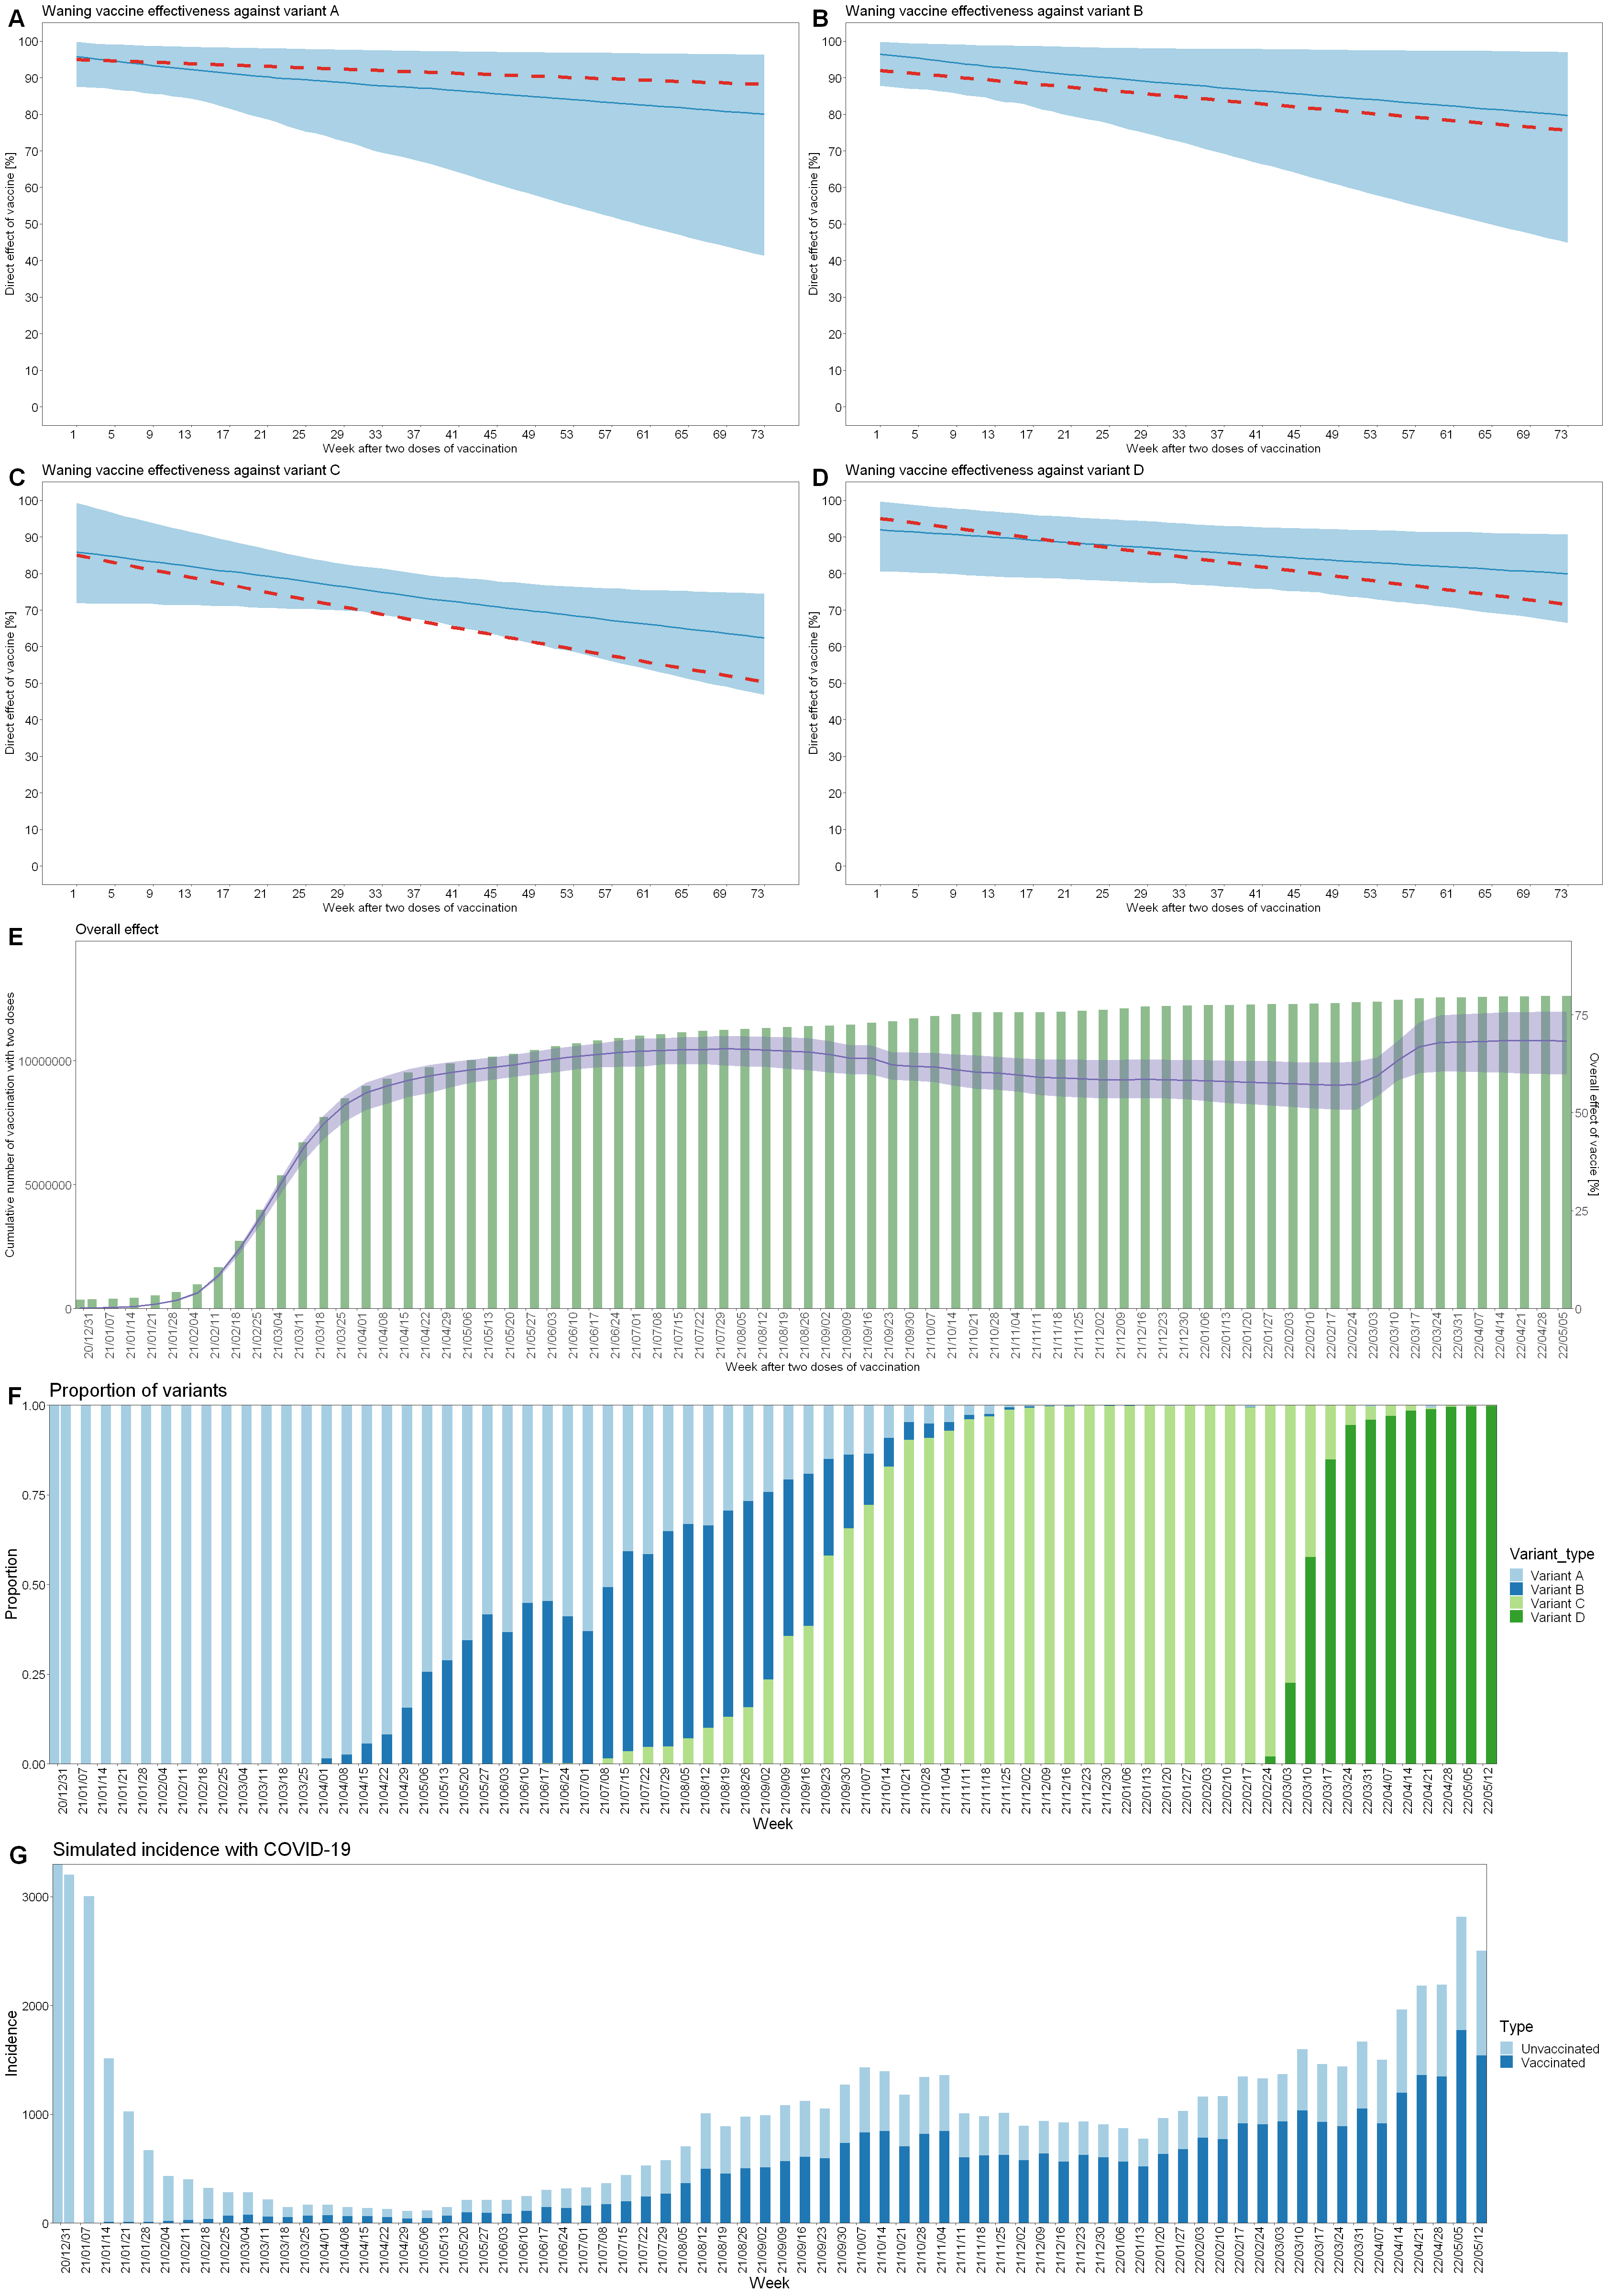

In [94]:
options(repr.plot.width=28,repr.plot.height=40)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, voc_plot, case_simulation, nrow=5,ncol=1,font.label=list(size=30),labels=c("","","E","F","G"),legend="right")

#ggsave(file = "output/VE_waning_simulation1_param.png", width = 28, height = 40)

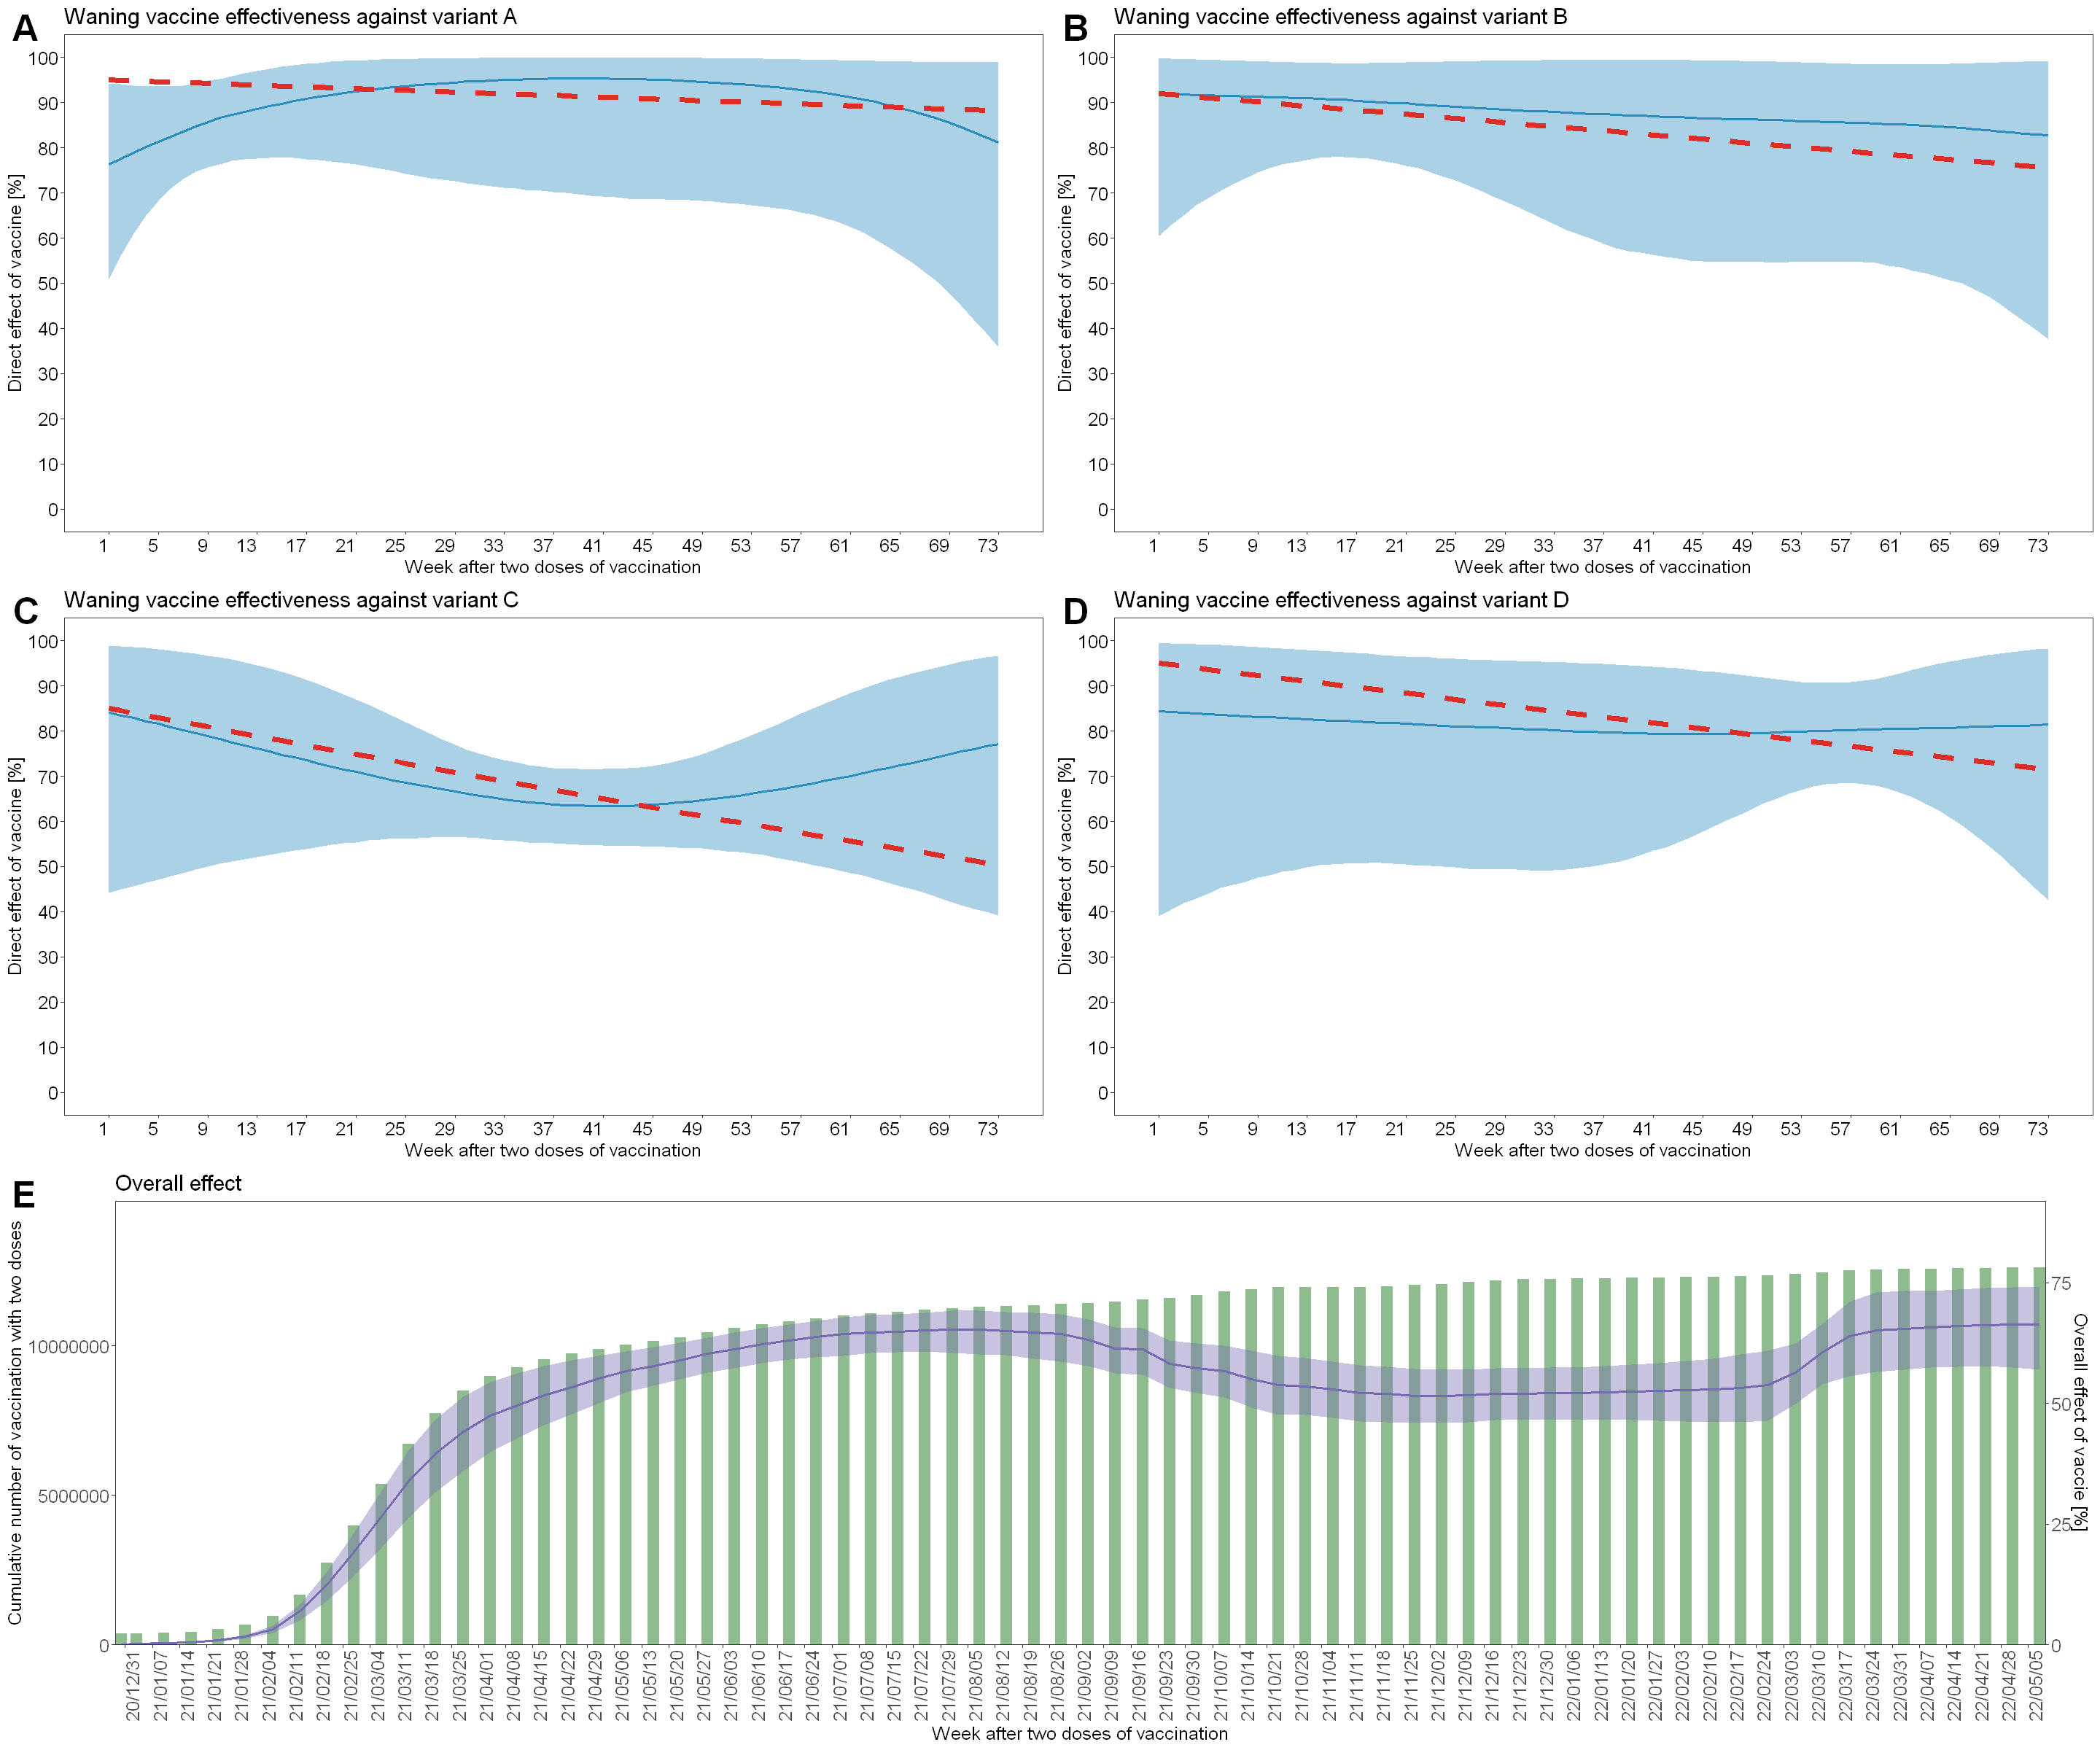

In [108]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"))

ggsave(file = "output/VE_waning_simulation1_spline.png", width = 24, height = 20)